In [57]:
import math
import matplotlib.pyplot as plt
import librosa.feature
import librosa.display
import numpy as np
from IPython.display import Audio, display
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import ruptures as rpt  # our package
import IPython.display as ipd
import pandas as pd


In [58]:
def fig_ax(figsize=(15, 5), dpi=150):
    """Return a (matplotlib) figure and ax objects with given size."""
    return plt.subplots(figsize=figsize, dpi=dpi)

In [ ]:
# GET THE SONG DURATION BY FILE
y, sr = librosa.load(r"Music-Structure-Analysis\DO NOT TOUCH\Audio Files\Emmanuel\01. Vitalic.flac", sr=None)
durationOfSong = librosa.get_duration(y=y, sr=sr)

signal, sr = librosa.load(
    r"Music-Structure-Analysis\DO NOT TOUCH\Audio Files\Emmanuel\01. Vitalic.flac",
    sr = None,                                                                      # <-- CAN BE CHANGED :))
    duration=durationOfSong
)

# GTS FOR LATER
GT = r"Music-Structure-Analysis\DO NOT TOUCH\GroundTruthData\GroundTruthRight\parsed_data_1.csv"
ground_truth_path = r"Music-Structure-Analysis\DO NOT TOUCH\GroundTruthData\GroundTruthRight\parsed_data_1.csv"

print("signal type: ", type(signal))
print(f"Loaded signal with shape: {signal.shape}, Sampling rate: {sr}")

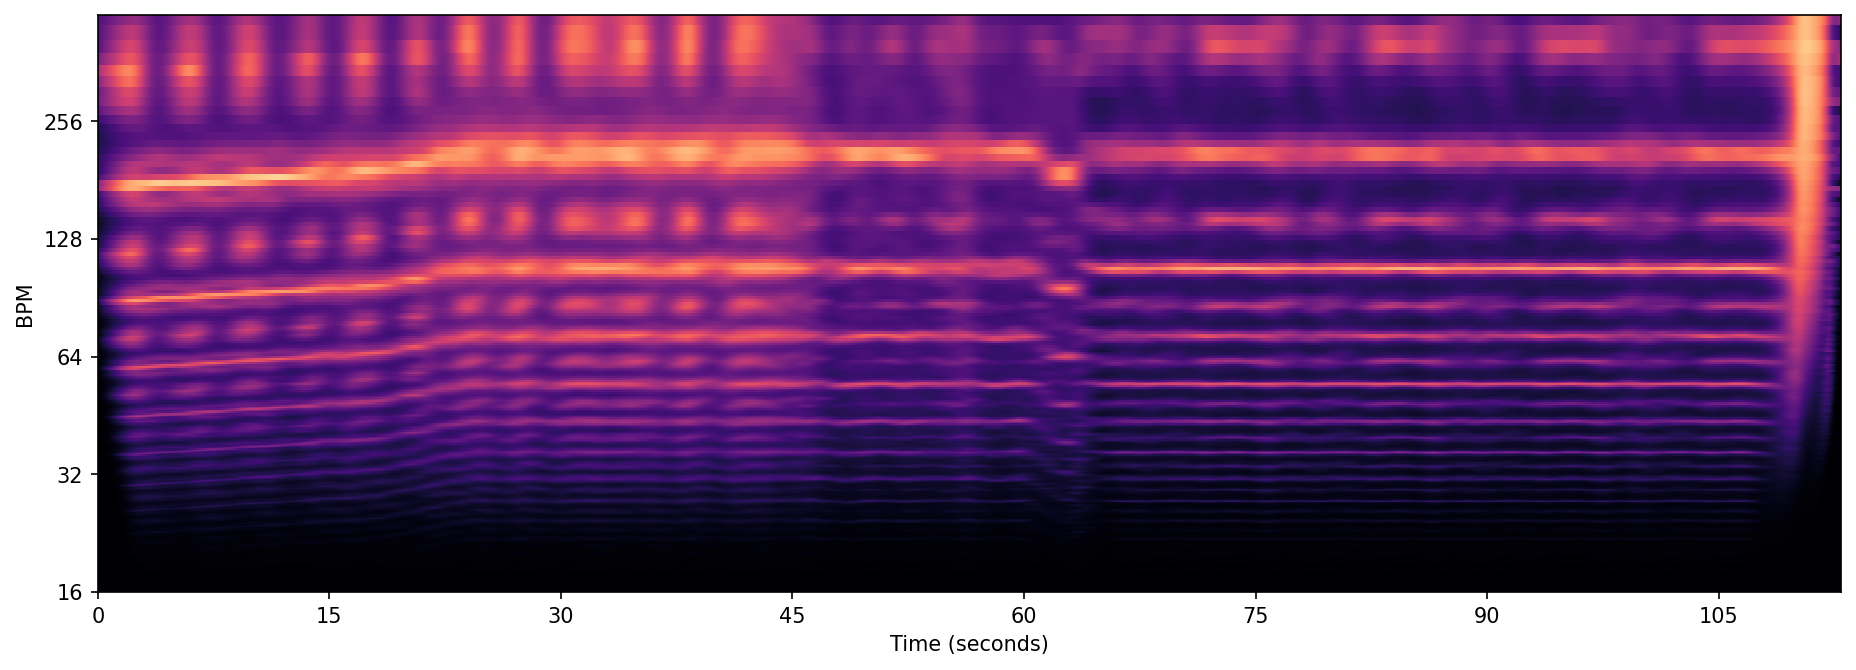

In [60]:
# Compute the onset strength
hop_length_tempo = 512                                                                       # <-- CAN BE CHANGED :))
oenv = librosa.onset.onset_strength(
    y=signal, sr=sr, hop_length=hop_length_tempo
)
# Compute the tempogram
tempogram = librosa.feature.tempogram(
    onset_envelope=oenv,
    sr=sr,
    hop_length=hop_length_tempo,
)
# Display the tempogram
fig, ax = fig_ax()
_ = librosa.display.specshow(
    tempogram,
    ax=ax,
    hop_length=hop_length_tempo,
    sr=sr,
    x_axis="s",
    y_axis="tempo",
)

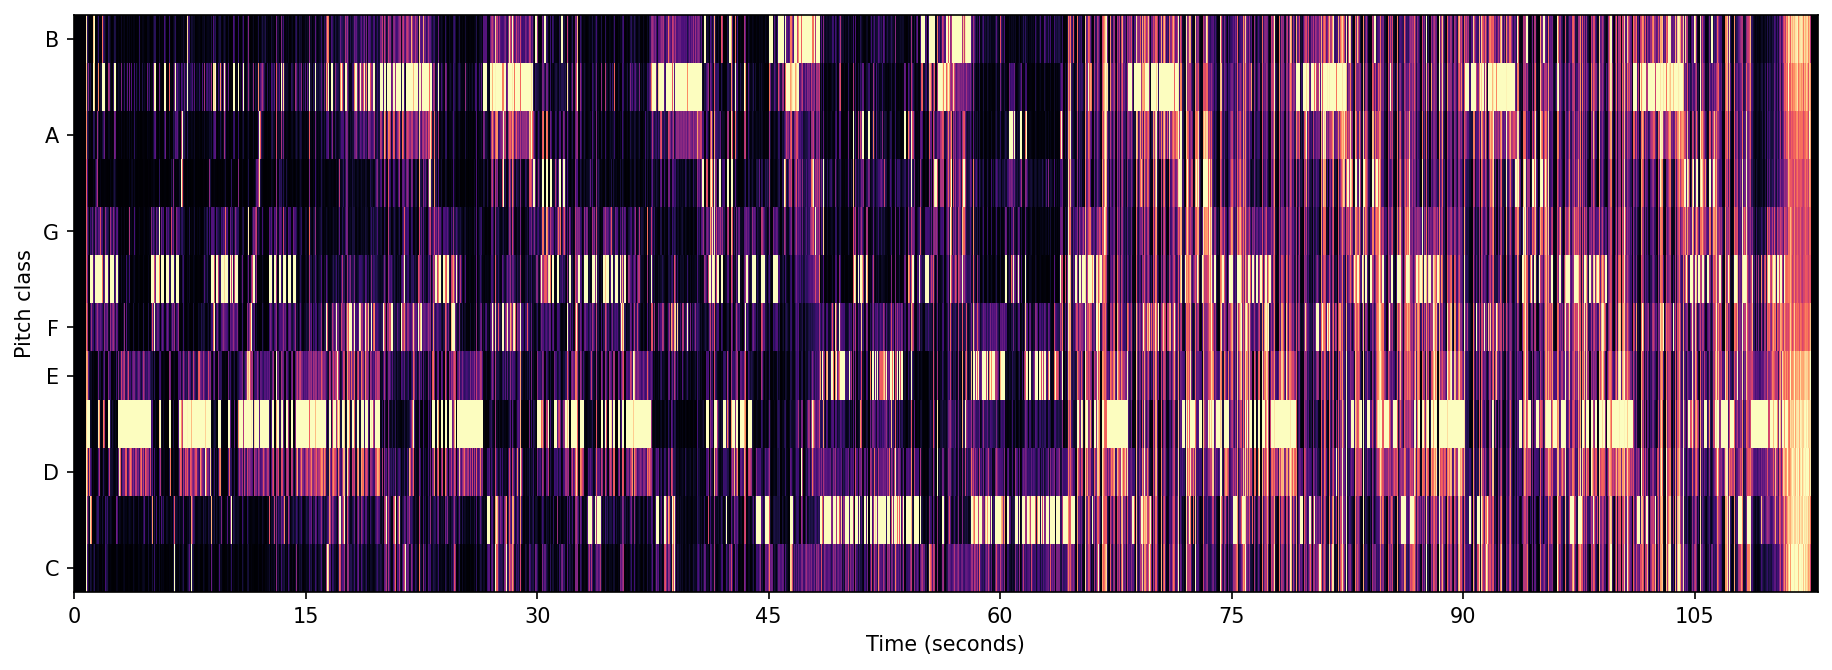

In [61]:
# Compute the Chromagram
# Extract chroma features (try chroma_cqt or chroma_cens)
chroma = librosa.feature.chroma_stft(y=signal, sr=sr, n_chroma=12)                       # <-- CAN BE CHANGED :))  - Go into the packages.. im sorry..

# Normalize chroma features
chroma = librosa.util.normalize(chroma, axis=1)                       # <-- see if this does anything

# Transpose to shape (time_steps, features)
chroma_T = chroma.T  # shape: (frames, 12)

# Display the chromagram
fig, ax = fig_ax()
_ = librosa.display.specshow(
    chroma,
    ax=ax,
    hop_length=hop_length_tempo,
    sr=sr,
    x_axis="s",
    y_axis="chroma",
    cmap = "magma"
)

Detected change points: [  0.71981859   4.87619048  10.84371882  16.28879819  21.46684807
  28.02648526  35.4800907   44.26884354  48.9476644   53.98639456
  60.70857143  71.37814059  76.34721088  82.12897959  87.19092971
  91.2892517   97.91854875 102.16780045 107.69414966 111.92018141
 112.95346939]


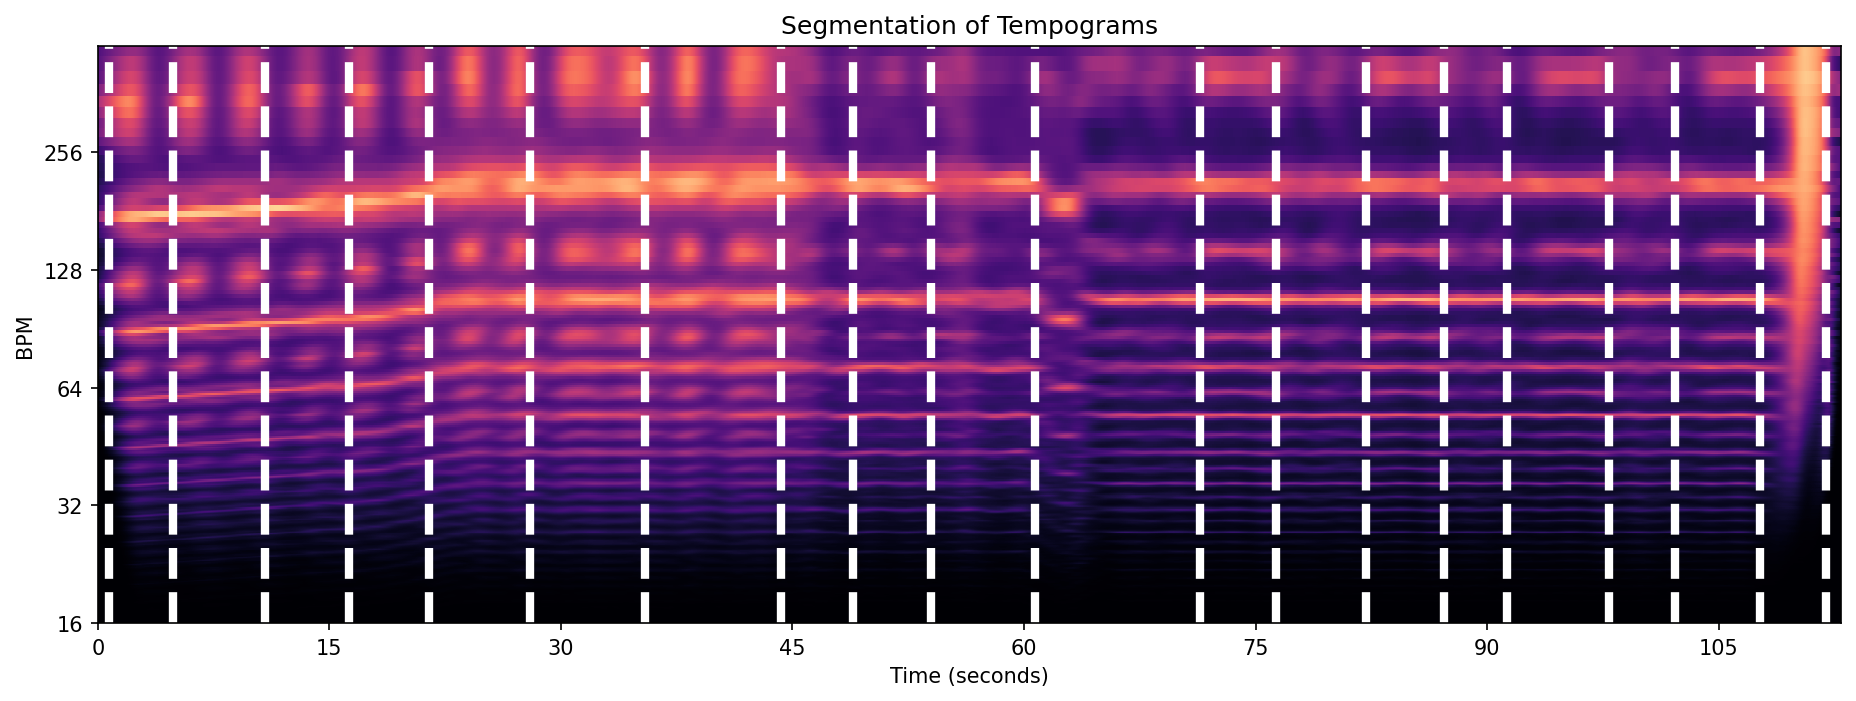

In [62]:
# Choose detection method TEMPOGRAMS
algoTEM = rpt.KernelCPD(kernel="cosine").fit(tempogram.T)                        # <-- CAN BE CHANGED :))

# === TEMPO ALGORITHM NUMBER OF DESIRED CHANGES (bkps) ===
n_bkps = 40                                                                    # <-- CAN BE CHANGED :))
bkpsTEM = algoTEM.predict(n_bkps=n_bkps)
bkps_timesTEM = librosa.frames_to_time(bkpsTEM, sr=sr, hop_length=512)


# === Ensure segments are at least desired seconds apart ===
min_segment_length = 4  # in seconds
filtered_bkps_times = [bkps_timesTEM[0]]  # Always keep the first change point
for b in bkps_timesTEM[1:]:
    if b - filtered_bkps_times[-1] >= min_segment_length:
        filtered_bkps_times.append(b)

# Ensure the final segment reaches the end
if filtered_bkps_times[-1] != bkps_timesTEM[-1]:
    filtered_bkps_times.append(bkps_timesTEM[-1])

# Use filtered breakpoints
bkps_timesTEM = np.array(filtered_bkps_times)

# Now bkps contains the detected change points
print(f"Detected change points: {bkps_timesTEM}")

# Displaying results
fig, ax = fig_ax()
_ = librosa.display.specshow(
    tempogram,
    label= "Segmentation of Tempograms",
    ax=ax,
    x_axis="s",
    y_axis="tempo",
    hop_length=hop_length_tempo,
    sr=sr,
)
# Add title
ax.set_title("Segmentation of Tempograms")

# === TEMPO IS WHITE LINES ===
for b in bkps_timesTEM[:-1]:
    ax.axvline(b, ls="--", color="white", lw=4)

Detected change points: [  0.75464853   6.78022676  12.64326531  19.82984127  24.84535147
  31.9506576   37.39573696  43.94376417  54.86875283  60.3138322
  68.26666667  73.70013605  79.18004535  84.61351474  90.09342404
  95.39918367 100.99519274 108.62294785 112.95346939]


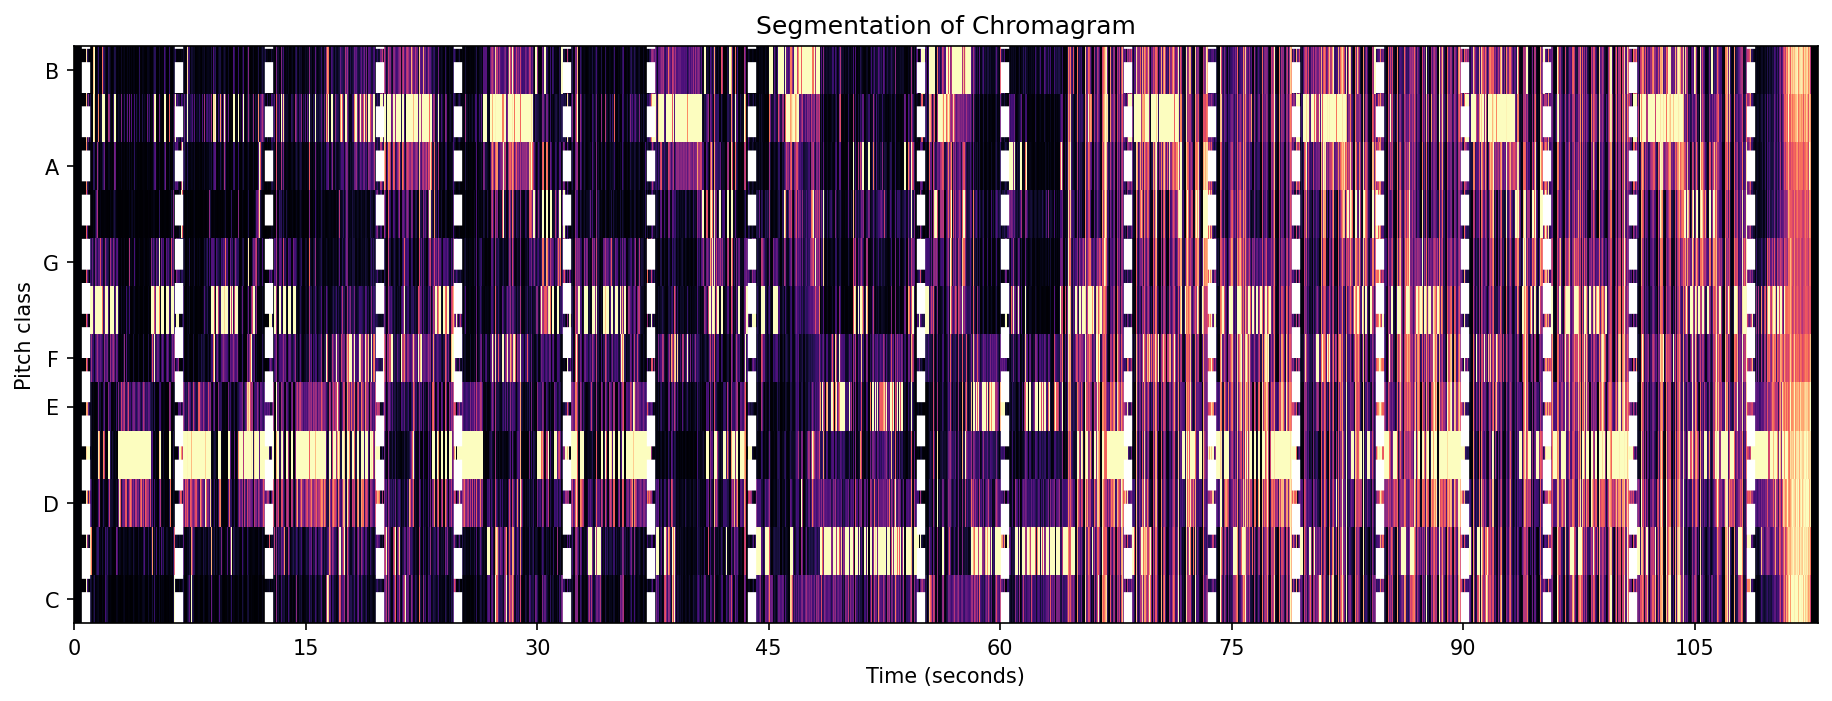

In [63]:
# Choose detection method CHROMAGRAMS
algoCH = rpt.KernelCPD(kernel="rbf").fit(chroma_T)                            # <-- CAN BE CHANGED :))

# === CHROMA ALGORITHM NUMBER OF DESIRED CHANGES (bkps) ===
bkpsCH = algoCH.predict(n_bkps=n_bkps)
bkpsCH_times = librosa.frames_to_time(bkpsCH, sr=sr, hop_length=hop_length_tempo)

# === Ensure segments are at least desired seconds apart ===
min_segment_lengthChroma = 5  # in seconds
filtered_bkpsCH_times = [bkpsCH_times[0]]  # Always keep the first change point
for b in bkpsCH_times[1:]:
    if b - filtered_bkpsCH_times[-1] >= min_segment_lengthChroma:
        filtered_bkpsCH_times.append(b)

# Ensure the final segment reaches the end
if filtered_bkpsCH_times[-1] != bkpsCH_times[-1]:
    filtered_bkpsCH_times.append(bkpsCH_times[-1])

# Use filtered breakpoints
bkpsCH_times = np.array(filtered_bkpsCH_times)

# Displaying results
fig, ax = fig_ax()
_ = librosa.display.specshow(
    chroma,
    ax=ax,
    x_axis="s",
    y_axis="chroma",
    hop_length=hop_length_tempo,
    sr=sr,
)
# Add title
ax.set_title("Segmentation of Chromagram")

# === CHROMA IS WHITE LINES ===
for b in bkpsCH_times[:-1]:
    ax.axvline(b, ls="--", color="white", lw=4)

print("Detected change points:", bkpsCH_times)

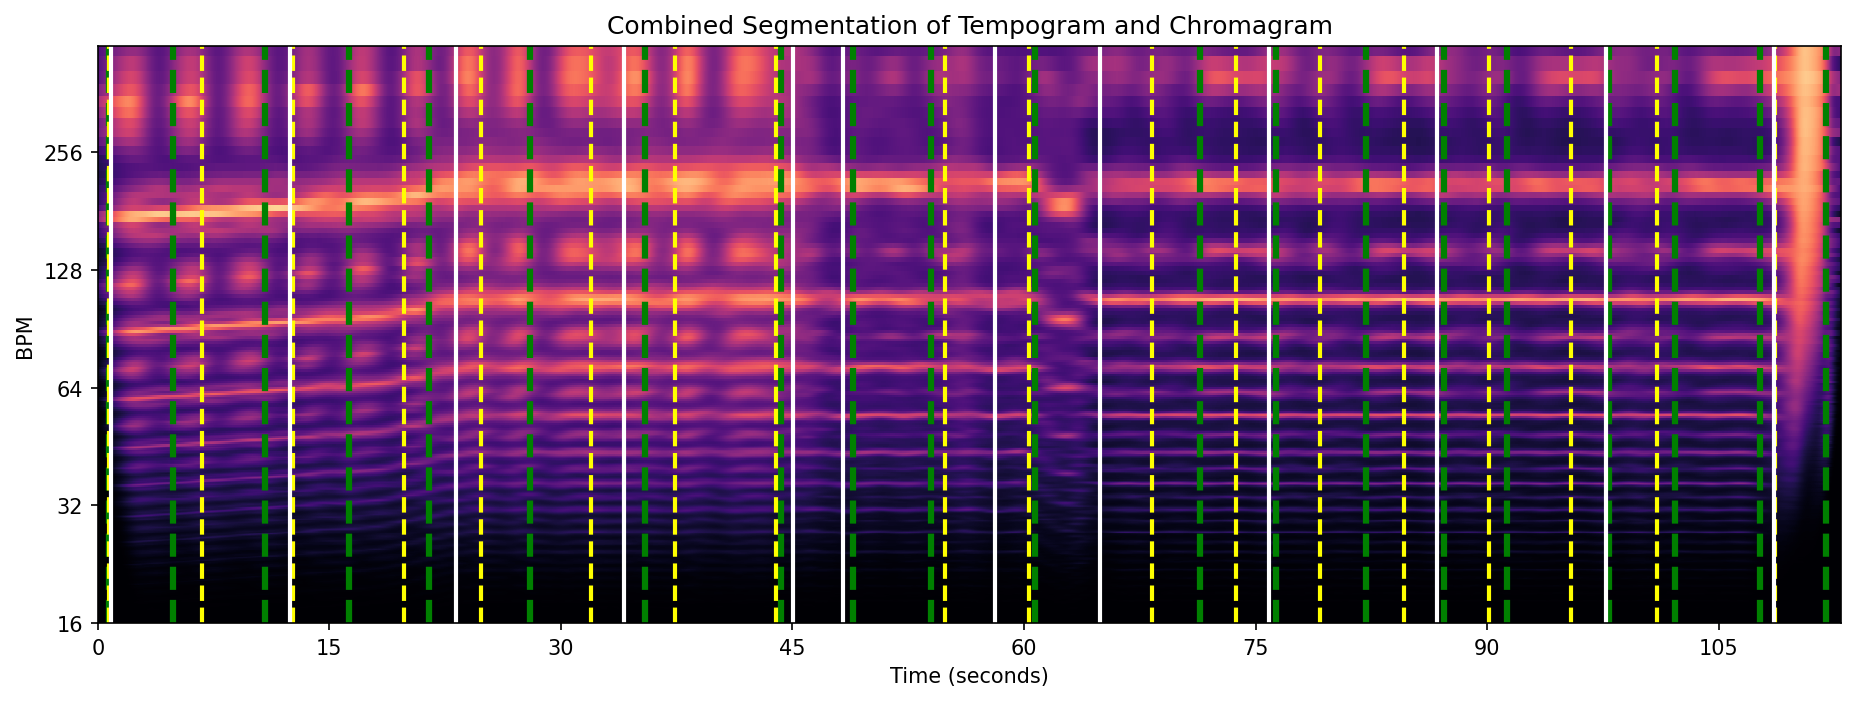

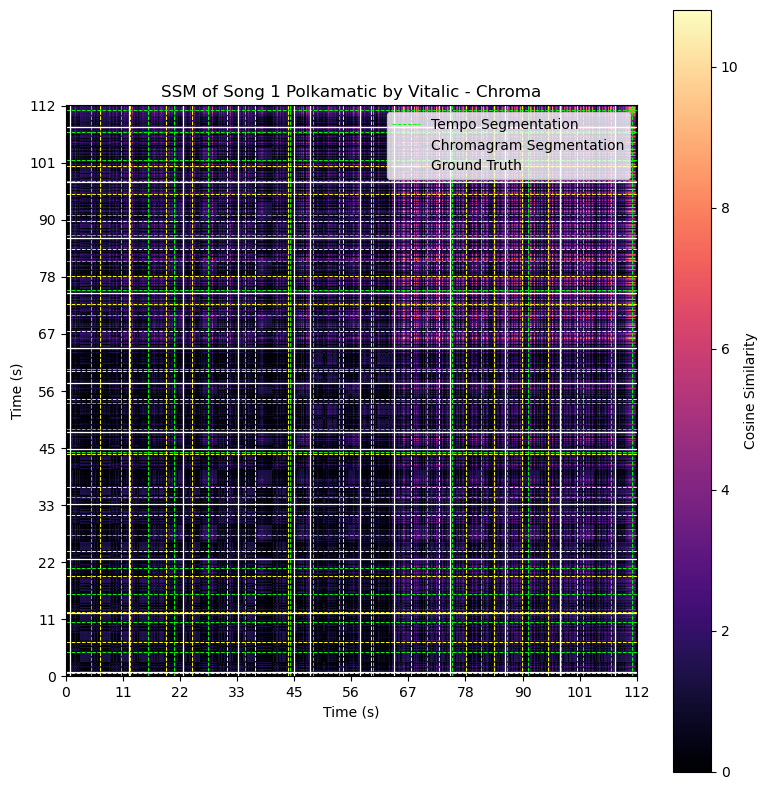

In [64]:
# === NOW COMPARE BOTH WITH GroundTruth ===
# Load GT only TIMESTAMPS
gt_data = pd.read_csv(GT)
gt_times = gt_data["TIMESTAMP"].values

# display the figure
fig, ax = fig_ax()
# Display the tempogram as the background
_ = librosa.display.specshow(
    tempogram,
    ax=ax,
    x_axis="s",
    y_axis="tempo",
    hop_length=hop_length_tempo,
    sr=sr,
)
# Title
ax.set_title("Combined Segmentation of Tempogram and Chromagram")


# === TEMPO IS GREEN LINES ===
for b in bkps_timesTEM[:-1]:
    ax.axvline(b, ls="--", color="green", lw=3, label="Tempo Segmentation" if b == bkps_timesTEM[0] else None)

# === CHROMA IS Yellow LINES ===
for b in bkpsCH_times[:-1]:
    ax.axvline(b, ls="--", color="yellow", lw=2, label="Chromagram Segmentation" if b == bkpsCH_times[0] else None)

# === GroundTruth IS WHITE LINES ===
for b in gt_times:
    ax.axvline(b, ls="-", color="white", lw=2, label="Ground Truth" if b == gt_times[0] else None)
plt.show()

# --- Compute the chromagram ---
chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
chroma_norm = librosa.util.normalize(chroma, axis=0)

# --- Compute the Self-Similarity Matrix (SSM) ---
ssm = np.dot(chroma_norm.T, chroma_norm)
n_frames = chroma.shape[1]  # total number of frames

# --- Convert segmentation times (in seconds) to frame indices ---
def seconds_to_frames(times_in_seconds, sr, hop_length):
    return (np.array(times_in_seconds) * sr / hop_length).astype(int)

bkpsTEM_frames = np.clip(seconds_to_frames(bkps_timesTEM, sr, hop_length=512), 0, n_frames - 1)
bkpsCH_frames = np.clip(seconds_to_frames(bkpsCH_times, sr, hop_length=512), 0, n_frames - 1)
gt_frames = np.clip(seconds_to_frames(gt_times, sr, hop_length=512), 0, n_frames - 1)

# --- Convert frame indices to times for tick labels ---
frame_times = librosa.frames_to_time(np.arange(n_frames), sr=sr, hop_length=512)
tick_spacing = max(1, int(n_frames / 10))  # ~10 ticks
tick_positions = np.arange(0, n_frames, tick_spacing)
tick_labels = frame_times[tick_positions].astype(int)

# --- Plot the SSM ---
plt.figure(figsize=(8, 8))
plt.imshow(ssm, origin='lower', cmap='magma', interpolation='nearest', aspect='equal')
plt.title('SSM of Song 1 Polkamatic by Vitalic - Chroma')
plt.xlabel('Time (s)')
plt.ylabel('Time (s)')
plt.colorbar(label='Cosine Similarity')

# --- Set tick marks to show time in seconds ---
plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)

# --- Overlay segmentation lines ---
for i, b in enumerate(bkpsTEM_frames[:-1]):
    plt.axvline(b, color='lime', lw=0.7, linestyle='--', label='Tempo Segmentation' if i == 0 else None)
    plt.axhline(b, color='lime', lw=0.7, linestyle='--')

for i, b in enumerate(bkpsCH_frames[:-1]):
    plt.axvline(b, color='yellow', lw=0.7, linestyle='--', label='Chromagram Segmentation' if i == 0 else None)
    plt.axhline(b, color='yellow', lw=0.7, linestyle='--')

for i, b in enumerate(gt_frames):
    plt.axvline(b, color='white', lw=0.9, linestyle='-', label='Ground Truth' if i == 0 else None)
    plt.axhline(b, color='white', lw=0.9, linestyle='-')

# --- Final touches ---
plt.xlim(0, n_frames)
plt.ylim(0, n_frames)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

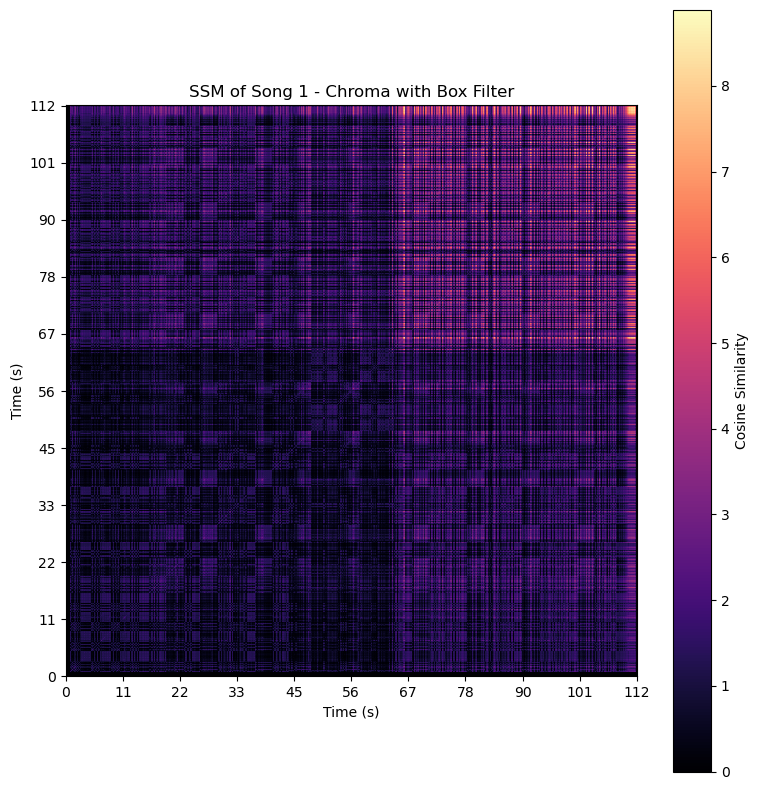

In [65]:
from scipy.ndimage import gaussian_filter1d, uniform_filter1d
# --- Choose filter type: "gaussian" or "box" ---
filter_type = "box"  # or "box"

# === Load ground truth ===
gt_data = pd.read_csv(GT)
gt_times = gt_data["TIMESTAMP"].values

# === Compute Chromagram ===
chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
chroma_norm = librosa.util.normalize(chroma, axis=0)

# === Apply smoothing for SSM ONLY ===
if filter_type == "gaussian":
    chroma_for_ssm = gaussian_filter1d(chroma_norm, sigma=1, axis=1)
elif filter_type == "box":
    chroma_for_ssm = uniform_filter1d(chroma_norm, size=5, axis=1)
else:
    raise ValueError("Invalid filter_type. Use 'gaussian' or 'box'.")

# === Compute the Self-Similarity Matrix (SSM) ===
ssm = np.dot(chroma_for_ssm.T, chroma_for_ssm)
n_frames = chroma.shape[1]

# --- Convert segmentation times (in seconds) to frame indices ---
def seconds_to_frames(times_in_seconds, sr, hop_length):
    return (np.array(times_in_seconds) * sr / hop_length).astype(int)

bkpsTEM_frames = np.clip(seconds_to_frames(bkps_timesTEM, sr, hop_length=512), 0, n_frames - 1)
bkpsCH_frames = np.clip(seconds_to_frames(bkpsCH_times, sr, hop_length=512), 0, n_frames - 1)
gt_frames = np.clip(seconds_to_frames(gt_times, sr, hop_length=512), 0, n_frames - 1)

# --- Convert frame indices to times for tick labels ---
frame_times = librosa.frames_to_time(np.arange(n_frames), sr=sr, hop_length=512)
tick_spacing = max(1, int(n_frames / 10))
tick_positions = np.arange(0, n_frames, tick_spacing)
tick_labels = frame_times[tick_positions].astype(int)

# === Plot the SSM ===
plt.figure(figsize=(8, 8))
plt.imshow(ssm, origin='lower', cmap='magma', interpolation='nearest', aspect='equal')
plt.title(f'SSM of Song 1 - Chroma with {filter_type.capitalize()} Filter')
plt.xlabel('Time (s)')
plt.ylabel('Time (s)')
plt.colorbar(label='Cosine Similarity')

# === Set ticks ===
plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)

# === Overlay segmentation lines ===


plt.xlim(0, n_frames)
plt.ylim(0, n_frames)

plt.tight_layout()
plt.show()


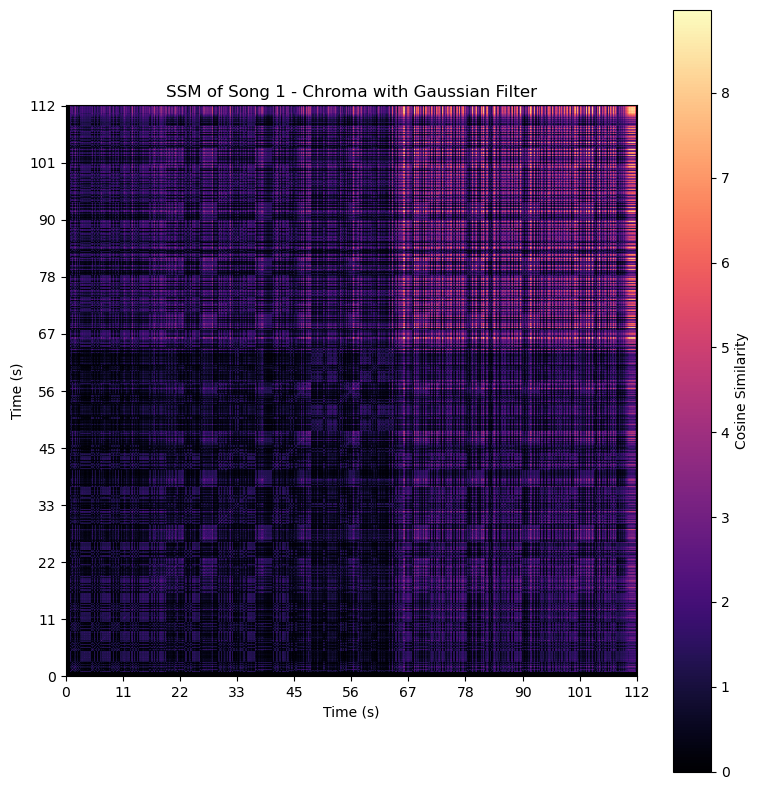

In [74]:
from scipy.ndimage import gaussian_filter1d, uniform_filter1d
# --- Choose filter type: "gaussian" or "box" ---
filter_type = "gaussian"  # or "box"

# === Load ground truth ===
gt_data = pd.read_csv(GT)
gt_times = gt_data["TIMESTAMP"].values

# === Compute Chromagram ===
chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
chroma_norm = librosa.util.normalize(chroma, axis=0)

# === Apply smoothing for SSM ONLY ===
if filter_type == "gaussian":
    chroma_for_ssm = gaussian_filter1d(chroma_norm, sigma=1, axis=1)
elif filter_type == "box":
    chroma_for_ssm = uniform_filter1d(chroma_norm, size=5, axis=1)
else:
    raise ValueError("Invalid filter_type. Use 'gaussian' or 'box'.")

# === Compute the Self-Similarity Matrix (SSM) ===
ssm = np.dot(chroma_for_ssm.T, chroma_for_ssm)
n_frames = chroma.shape[1]

# --- Convert segmentation times (in seconds) to frame indices ---
def seconds_to_frames(times_in_seconds, sr, hop_length):
    return (np.array(times_in_seconds) * sr / hop_length).astype(int)

bkpsTEM_frames = np.clip(seconds_to_frames(bkps_timesTEM, sr, hop_length=512), 0, n_frames - 1)
bkpsCH_frames = np.clip(seconds_to_frames(bkpsCH_times, sr, hop_length=512), 0, n_frames - 1)
gt_frames = np.clip(seconds_to_frames(gt_times, sr, hop_length=512), 0, n_frames - 1)

# --- Convert frame indices to times for tick labels ---
frame_times = librosa.frames_to_time(np.arange(n_frames), sr=sr, hop_length=512)
tick_spacing = max(1, int(n_frames / 10))
tick_positions = np.arange(0, n_frames, tick_spacing)
tick_labels = frame_times[tick_positions].astype(int)

# === Plot the SSM ===
plt.figure(figsize=(8, 8))
plt.imshow(ssm, origin='lower', cmap='magma', interpolation='nearest', aspect='equal')
plt.title(f'SSM of Song 1 - Chroma with {filter_type.capitalize()} Filter')
plt.xlabel('Time (s)')
plt.ylabel('Time (s)')
plt.colorbar(label='Cosine Similarity')

# === Set ticks ===
plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)

# === Overlay segmentation lines ===


plt.xlim(0, n_frames)
plt.ylim(0, n_frames)

plt.tight_layout()
plt.show()

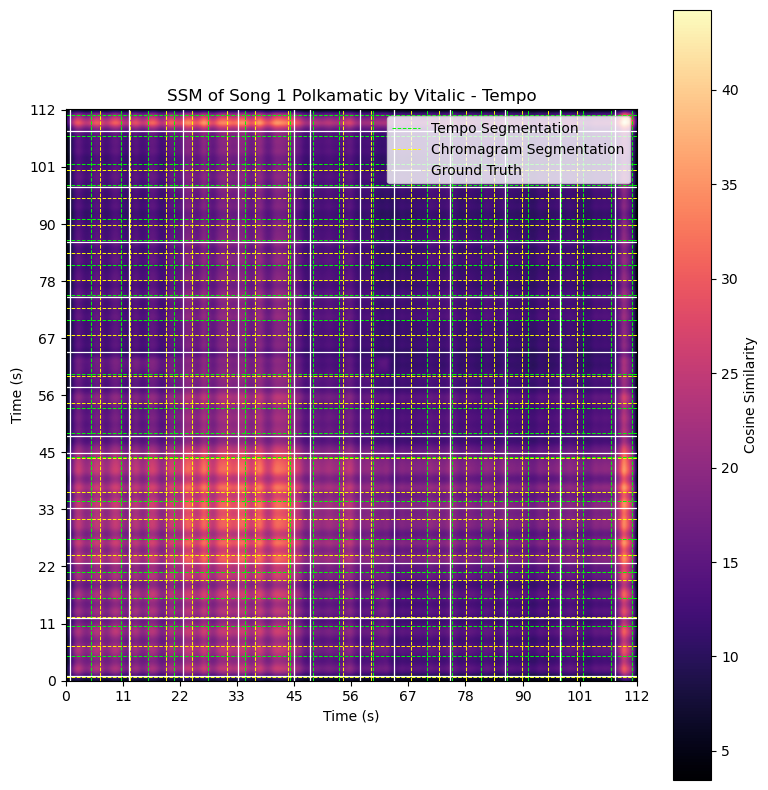

In [68]:
# === NOW COMPARE BOTH WITH GroundTruth ===
# Load GT only TIMESTAMPS
gt_data = pd.read_csv(GT)
gt_times = gt_data["TIMESTAMP"].values

# === TEMPO IS GREEN LINES ===
for b in bkps_timesTEM[:-1]:
    ax.axvline(b, ls="--", color="green", lw=3, label="Tempo Segmentation" if b == bkps_timesTEM[0] else None)

# === CHROMA IS Yellow LINES ===
for b in bkpsCH_times[:-1]:
    ax.axvline(b, ls="--", color="yellow", lw=2, label="Chromagram Segmentation" if b == bkpsCH_times[0] else None)

# === GroundTruth IS WHITE LINES ===
for b in gt_times:
    ax.axvline(b, ls="-", color="white", lw=2, label="Ground Truth" if b == gt_times[0] else None)
plt.show()

# --- Compute the tempogram ---
tempogram = librosa.feature.tempogram(y=y, sr=sr, hop_length=hop_length_tempo)
tempogram_norm = librosa.util.normalize(tempogram, axis=0)

# --- Compute the Self-Similarity Matrix (SSM) using tempogram ---
ssm = np.dot(tempogram_norm.T, tempogram_norm)
n_frames = chroma.shape[1]  # total number of frames

# --- Convert segmentation times (in seconds) to frame indices ---
def seconds_to_frames(times_in_seconds, sr, hop_length):
    return (np.array(times_in_seconds) * sr / hop_length).astype(int)

bkpsTEM_frames = np.clip(seconds_to_frames(bkps_timesTEM, sr, hop_length=512), 0, n_frames - 1)
bkpsCH_frames = np.clip(seconds_to_frames(bkpsCH_times, sr, hop_length=512), 0, n_frames - 1)
gt_frames = np.clip(seconds_to_frames(gt_times, sr, hop_length=512), 0, n_frames - 1)

# --- Convert frame indices to times for tick labels ---
frame_times = librosa.frames_to_time(np.arange(n_frames), sr=sr, hop_length=512)
tick_spacing = max(1, int(n_frames / 10))  # ~10 ticks
tick_positions = np.arange(0, n_frames, tick_spacing)
tick_labels = frame_times[tick_positions].astype(int)

# --- Plot the SSM ---
plt.figure(figsize=(8, 8))
plt.imshow(ssm, origin='lower', cmap='magma', interpolation='nearest', aspect='equal')
plt.title('SSM of Song 1 Polkamatic by Vitalic - Tempo')
plt.xlabel('Time (s)')
plt.ylabel('Time (s)')
plt.colorbar(label='Cosine Similarity')

# --- Set tick marks to show time in seconds ---
plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)

# --- Overlay segmentation lines ---
for i, b in enumerate(bkpsTEM_frames[:-1]):
    plt.axvline(b, color='lime', lw=0.7, linestyle='--', label='Tempo Segmentation' if i == 0 else None)
    plt.axhline(b, color='lime', lw=0.7, linestyle='--')

for i, b in enumerate(bkpsCH_frames[:-1]):
    plt.axvline(b, color='yellow', lw=0.7, linestyle='--', label='Chromagram Segmentation' if i == 0 else None)
    plt.axhline(b, color='yellow', lw=0.7, linestyle='--')

for i, b in enumerate(gt_frames):
    plt.axvline(b, color='white', lw=0.9, linestyle='-', label='Ground Truth' if i == 0 else None)
    plt.axhline(b, color='white', lw=0.9, linestyle='-')

# --- Final touches ---
plt.xlim(0, n_frames)
plt.ylim(0, n_frames)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()